<a href="https://colab.research.google.com/github/Khaarl/VIZDOOM1/blob/main/RETROFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

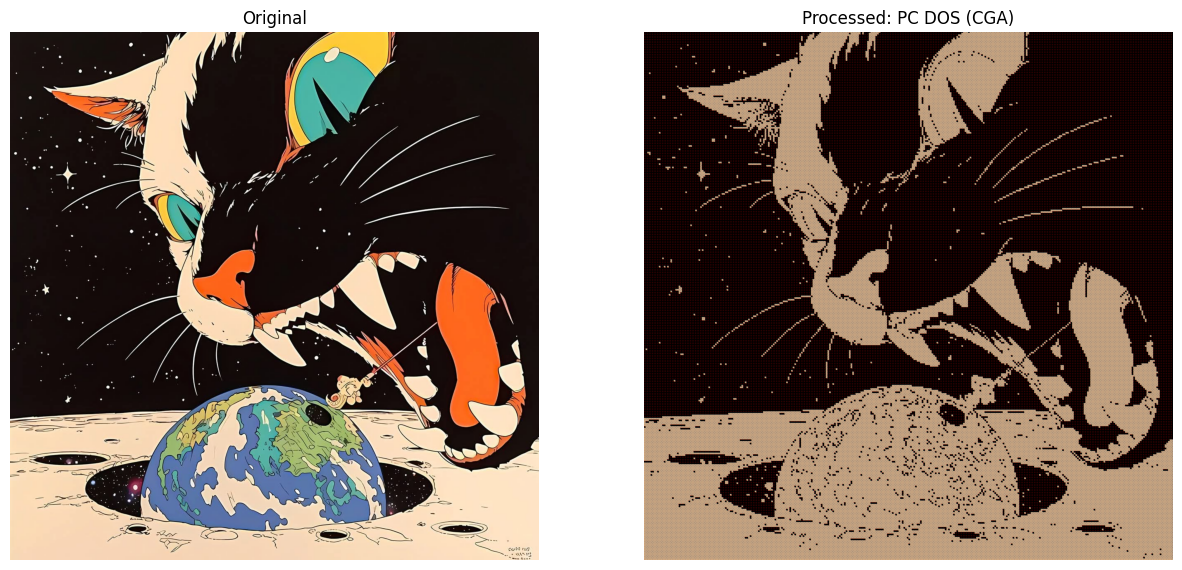

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved to: /content/drive/MyDrive/RETROFIER/retro_20250204_215227.png
📥 Downloaded: retro_20250204_215227.png


In [1]:
print("Welcome to RETROFIER - Nostalgia in Pixels!\n")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create RETROFIER folder
import os
retro_dir = '/content/drive/MyDrive/RETROFIER'
if not os.path.exists(retro_dir):
    os.makedirs(retro_dir)
    print(f"\n✅ Created RETROFIER folder in Google Drive")
else:
    print(f"\n🔄 Found existing RETROFIER folder")

# Core processing code
from PIL import Image, ImageDraw, ImageOps
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
import time

# ========== PALETTE DEFINITIONS ==========
PALETTES = {
    'gameboy': [
        (15, 56, 15), (48, 98, 48), (139, 172, 15), (155, 188, 15)
    ],
    'cga': [
        (0, 0, 0), (85, 255, 255), (255, 85, 255), (255, 255, 255)
    ],
    'amiga': [
        (0, 0, 0), (0, 0, 170), (0, 170, 0), (0, 170, 170),
        (170, 0, 0), (170, 0, 170), (170, 85, 0), (170, 170, 170),
        (85, 85, 85), (85, 85, 255), (85, 255, 85), (85, 255, 255),
        (255, 85, 85), (255, 85, 255), (255, 255, 85), (255, 255, 255)
    ],
    'zx': [
        (0,0,0), (0,0,255), (255,0,0), (255,0,255),
        (0,255,0), (0,255,255), (255,255,0), (255,255,255)
    ],
    'c64': [
        (0,0,0), (255,255,255), (136,0,0), (170,255,238),
        (204,68,204), (0,204,85), (0,0,170), (238,238,119),
        (221,136,85), (102,68,0), (255,119,119), (51,51,51),
        (119,119,119), (170,255,102), (0,136,255), (187,187,187)
    ],
    'nes': [
        (124,124,124), (0,0,252), (0,0,188), (68,40,188),
        (148,0,132), (168,0,32), (168,16,0), (136,20,0),
        (80,48,0), (0,120,0), (0,104,0), (0,88,0),
        (0,64,88), (0, 0, 0), (0, 0, 0), (0, 0, 0)
    ]
}

# ========== PRESET CONFIGURATION ==========
PRESET_SETTINGS = {
    'Custom': {'block_size': 8, 'matrix_size': 4, 'colors': 16, 'palette': 'none', 'grid': False},
    'AMIGA (OCS)': {'block_size': 8, 'matrix_size': 8, 'colors': 32, 'palette': 'amiga', 'grid': True},
    'PC DOS (CGA)': {'block_size': 4, 'matrix_size': 4, 'colors': 4, 'palette': 'cga', 'grid': False},
    'GAMEBOY': {'block_size': 16, 'matrix_size': 2, 'colors': 4, 'palette': 'gameboy', 'grid': True},
    'WIN 95': {'block_size': 6, 'matrix_size': 8, 'colors': 256, 'palette': 'none', 'grid': False},
    'ZX SPECTRUM': {'block_size': 8, 'matrix_size': 4, 'colors': 8, 'palette': 'zx', 'grid': True},
    'COMMODORE 64': {'block_size': 8, 'matrix_size': 4, 'colors': 16, 'palette': 'c64', 'grid': False},
    'NES': {'block_size': 16, 'matrix_size': 4, 'colors': 64, 'palette': 'nes', 'grid': True}
}

# ========== PROCESSING FUNCTIONS ==========
def bayer_threshold_map(size):
    """Generate Bayer threshold matrix (power of 2)"""
    if size == 2:
        return np.array([[0, 2], [3, 1]])
    smaller = bayer_threshold_map(size // 2)
    return np.block([[4*smaller, 4*smaller+2], [4*smaller+3, 4*smaller+1]])

def apply_palette(image, palette_name):
    """Apply custom color palette with dithering"""
    if palette_name not in PALETTES:
        return image

    palette = PALETTES[palette_name]
    pal_image = Image.new("P", (1, 1))
    pal_image.putpalette([c for rgb in palette for c in rgb])

    # Convert to RGB and quantize to the palette with dithering
    return image.convert("RGB").quantize(
        palette=pal_image,
        dither=Image.Dither.FLOYDSTEINBERG
    ).convert('RGB')

def bayer_dither(image, matrix_size):
    """Apply Bayer ordered dithering to each RGB channel"""
    img = image.convert('RGB')
    arr = np.array(img)
    bayer = bayer_threshold_map(matrix_size)
    tile_size = matrix_size

    height, width, _ = arr.shape
    for y in range(height):
        for x in range(width):
            for c in range(3):  # R, G, B channels
                value = arr[y, x, c]
                threshold = (bayer[x % tile_size, y % tile_size] + 1) * (255 / (tile_size**2 + 1))
                arr[y, x, c] = 0 if value < threshold else 255
    return Image.fromarray(arr, mode='RGB')

def add_pixel_grid(image, block_size):
    """Add pixel grid overlay"""
    grid = Image.new('L', image.size, 255)
    draw = ImageDraw.Draw(grid)
    for x in range(0, image.width, block_size):
        draw.line([(x,0), (x,image.height)], fill=0, width=1)
    for y in range(0, image.height, block_size):
        draw.line([(0,y), (image.width,y)], fill=0, width=1)
    return Image.composite(image, Image.new('RGB', image.size, (255,255,255)), grid)

# ========== UI COMPONENTS ==========
preset_selector = widgets.Dropdown(
    options=list(PRESET_SETTINGS.keys()),
    value='Custom',
    description='🎚️ Preset:',
    style={'description_width': 'initial'}
)

block_size = widgets.IntSlider(
    value=8, min=1, max=64, step=1,
    description='🖼️ Block Size:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

matrix_size = widgets.Dropdown(
    options=[2, 4, 8, 16],
    value=4,
    description='🎛️ Dither Matrix:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

colors = widgets.IntSlider(
    value=16, min=2, max=256, step=2,
    description='🎨 Colors:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

grid_toggle = widgets.Checkbox(
    value=False,
    description='➕ Add Pixel Grid',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

palette_selector = widgets.Dropdown(
    options=['none'] + list(PALETTES.keys()),
    value='none',
    description='🌈 Palette:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

process_btn = widgets.Button(
    description="🔄 Process Image",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

filename_input = widgets.Text(
    value='',
    placeholder='Enter filename (optional)',
    description='💾 Save as:',
    layout=widgets.Layout(width='400px')
)

# ========== UI LAYOUT ==========
header = widgets.HTML(
    value="<h2 style='color: #4CAF50; text-align: center'>🕹️ RETROFIER Controls</h2>"
)

controls = widgets.VBox([
    preset_selector,
    block_size,
    matrix_size,
    colors,
    grid_toggle,
    palette_selector
], layout=widgets.Layout(align_items='center'))

footer = widgets.HTML(
    value="<div style='text-align: center; margin-top: 20px'>"
          "💡 Tip: Start with GAMEBOY preset for classic handheld console look!"
          "</div>"
)

ui = widgets.VBox([
    header,
    controls,
    widgets.HBox([process_btn], layout=widgets.Layout(justify_content='center')),
    footer
], layout=widgets.Layout(
    padding='20px',
    border='2px solid #4CAF50',
    border_radius='10px'
))

# ========== PROCESSING HANDLERS ==========
class RetroProcessor:
    def __init__(self):
        self.current_image = None
        self.processed_image = None

    def reset(self):
        self.current_image = None
        self.processed_image = None
        clear_output()
        display(ui)
        print("🔄 Session reset - Upload a new image to start over")

retro_processor = RetroProcessor()

def apply_preset(change):
    """Update controls with preset values"""
    preset_name = change['new']
    if preset_name == 'Custom':
        return

    settings = PRESET_SETTINGS[preset_name]
    block_size.value = settings['block_size']
    matrix_size.value = settings['matrix_size']
    colors.value = settings['colors']
    palette_selector.value = settings['palette']
    grid_toggle.value = settings['grid']

def on_process_click(btn):
    clear_output()
    display(ui)
    print("Step 1: Upload your image")
    upload = files.upload()

    if upload:
        retro_processor.current_image = Image.open(next(iter(upload))).convert('RGB')
        process_image()

def process_image():
    if retro_processor.current_image:
        try:
            img = retro_processor.current_image.copy()

            params = {
                'block_size': block_size.value,
                'matrix_size': matrix_size.value,
                'colors': colors.value,
                'grid': grid_toggle.value,
                'palette': palette_selector.value
            }

            # Pixelation
            img = img.resize(
                (img.width // params['block_size'],
                 img.height // params['block_size']),
                Image.Resampling.NEAREST
            ).resize(
                retro_processor.current_image.size,
                Image.Resampling.NEAREST
            )

            # Color reduction and dithering
            if params['palette'] != 'none':
                img = apply_palette(img, params['palette'])
            else:
                if params['colors'] < 256:
                    img = img.quantize(params['colors'], dither=Image.Dither.FLOYDSTEINBERG).convert('RGB')
                if params['matrix_size'] > 0:
                    img = bayer_dither(img, params['matrix_size'])

            # Grid overlay
            if params['grid']:
                img = add_pixel_grid(img, params['block_size'])

            retro_processor.processed_image = img

            # Display results
            clear_output(wait=True)
            display(ui)
            plt.figure(figsize=(15, 8))

            plt.subplot(1, 2, 1)
            plt.imshow(retro_processor.current_image)
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(retro_processor.processed_image)
            plt.title(f"Processed: {preset_selector.value}")
            plt.axis('off')

            plt.show()
            display_post_processing()

        except Exception as e:
            print(f"⚠️ Processing error: {str(e)}")
            retro_processor.reset()

def display_post_processing():
    post_ui = widgets.VBox([
        filename_input,
        widgets.HBox([
            widgets.Button(description="🔄 Reprocess",
                         button_style='info',
                         layout=widgets.Layout(width='150px')),
            widgets.Button(description="💾 Download",
                         button_style='success',
                         layout=widgets.Layout(width='150px')),
            widgets.Button(description="🚫 Exit",
                         button_style='danger',
                         layout=widgets.Layout(width='150px'))
        ])
    ])

    def on_reprocess(b):
        try:
            clear_output(wait=True)
            display(ui)
            process_image()
        except Exception as e:
            print(f"⚠️ Reprocessing error: {str(e)}")
            retro_processor.reset()

    def on_download(b):
        try:
            if retro_processor.processed_image:
                filename = filename_input.value.strip() or \
                         f"retro_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
                if not filename.lower().endswith('.png'):
                    filename += '.png'

                # Save to Google Drive
                drive_path = f'{retro_dir}/{filename}'
                retro_processor.processed_image.save(drive_path)

                # Save to local
                retro_processor.processed_image.save(filename)
                files.download(filename)

                print(f"✅ Saved to: {drive_path}\n📥 Downloaded: {filename}")
        except Exception as e:
            print(f"⚠️ Download error: {str(e)}")

    def on_exit(b):
        retro_processor.reset()

    post_ui.children[1].children[0].on_click(on_reprocess)
    post_ui.children[1].children[1].on_click(on_download)
    post_ui.children[1].children[2].on_click(on_exit)

    display(post_ui)

# ========== INITIALIZE ==========
preset_selector.observe(apply_preset, names='value')
process_btn.on_click(on_process_click)
display(ui)
print("\n🚀 Ready to retro-fy your images! Click 'Process Image' to start")